In [2]:
import numpy as np
import pandas as pd
from itertools import permutations
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_dataset(sigma: float):
    samples1 = np.random.multivariate_normal(\
        np.array([-1, -1]), sigma * np.array([[2, 0.5], [0.5, 1]]), 100)
    samples2 = np.random.multivariate_normal(\
        np.array([1, -1]), sigma * np.array([[1, -0.5], [-0.5, 2]]), 100)
    samples3 = np.random.multivariate_normal(\
        np.array([0, 1]), sigma * np.array([[1, 0], [0, 2]]), 100)
    dataset = np.concatenate((samples1, samples2, samples3))
    labels = [0] * 100 + [1] * 100 + [2] * 100
    return (dataset, np.array(labels))

In [3]:
def km_clustering(X: np.array, K: int) -> (np.array, np.array):
    # randomly select k centroids
    dbounds = [(np.min(X[:, i]), np.max(X[:, i])) for i in range(X.shape[1])]
    centers = np.array([[np.random.random_sample() * (dbounds[j][1] - dbounds[j][0]) + dbounds[j][0] \
                for j in range(len(dbounds))] for i in range(K)])
    converged = False
    Y = np.zeros(X.shape[0])
    iteration = 0
    while not converged:
        iteration += 1
        change = False
        # assign each x to a centroid
        for i in range(len(X)):
            prev_y = Y[i]
            x = X[i]
            distances = np.linalg.norm(centers - x, axis=1)
            closest_center = np.argmin(distances)
            Y[i] = closest_center
            if Y[i] != prev_y:
                change = True
        # update each centroid
        for k in range(len(centers)):
            cluster_points = [X[j] for j in np.where(Y == k)[0]]
            centers[k] = np.mean(cluster_points, axis=0)
        # if no centroid assignment changed, we've converged
        if not change:
            converged = True
            print('Converged after ' + str(iteration) + ' iterations.')
    return (centers, Y)

In [4]:
def gaussian_prob(x: np.array, mean: np.array, cov: np.array) -> float:
    det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    exp = np.exp(-0.5 * ((x - mean) @ cov_inv @ (x - mean).T))
    coef = 1 / (np.sqrt((2 * np.pi)**len(x) * det))
    return coef * exp

def gmm_clustering(X: np.array, K: int, convergence_threshold: float=0.001) \
    -> (np.array, np.array, np.array, np.array):

    # initialize parameters
    means = X[np.random.choice(len(X), K, replace=False)]
    covs = np.array([np.identity(X.shape[1])] * K)
    pZ = np.array([1/K] * K)
    W = np.zeros((X.shape[0], K)) # Pr of each x belonging to each z

    converged = False
    iteration = 0
    while not converged:
        iteration += 1

        # E-step: estimate latent variables
        for i in range(len(X)):
            x = X[i]
            for j in range(K):
                prob = gaussian_prob(x, means[j], covs[j]) * pZ[j]
                W[i][j] = prob
        W /= W.sum(axis=1, keepdims=True)

        # M-step: maximize lower bound by updating parameters
        prev_pZ = pZ
        W_sum = W.sum(axis=0)
        pZ = W_sum / len(W)
        means = np.matmul(W.T, X) / W_sum[:, np.newaxis]
        for j in range(K):
            diff = (X - means[j]).T
            covs[j] = (W[:,j] * diff) @ diff.T / W_sum[j]
        # print('===Iteration #' + str(iteration) + '===')
        # print(means)
        # print(covs)
        # print(pZ)
        # Check for convergence
        if np.sum(np.abs(pZ - prev_pZ)) <= convergence_threshold:
            converged = True
            print('Converged after ' + str(iteration) + ' iterations.')
    return (means, covs, pZ, W)

In [5]:
def calc_accuracy(Y: np.array, Yp: np.array) -> (float, np.array):
    perms = list(permutations(np.unique(Y)))
    accuracies = []
    for perm in perms:
        num_correct = np.sum([1 if Y[i] == perm[Yp[i]] else 0 for i in range(len(Y))])
        accuracies.append(num_correct / len(Y))
    accuracies = np.array(accuracies)
    idx = np.argmax(accuracies)
    best_perm = np.array(perms[idx])
    best_acc = accuracies[idx]
    return (best_acc, best_perm)

def calc_objective(X: np.array, Y: np.array, centroids: np.array) -> float:
    obj = 0
    for k in range(len(centroids)):
        cluster_points = [X[j] for j in np.where(Y == k)[0]]
        distances = np.linalg.norm(cluster_points - centroids[k], axis=1)
        total_distance = np.sum(distances)
        obj += total_distance
    return obj

def calc_log_likelihood(X, means, covs, pZ):
    total_log_likelihood = 0
    K = len(means)
    for i in range(X.shape[0]):
        x = X[i]
        for j in range(K):
            prob = pZ[j] * gaussian_prob(x, means[j], covs[j])
            total_log_likelihood += np.log(prob)
    return total_log_likelihood

Converged after 10 iterations.


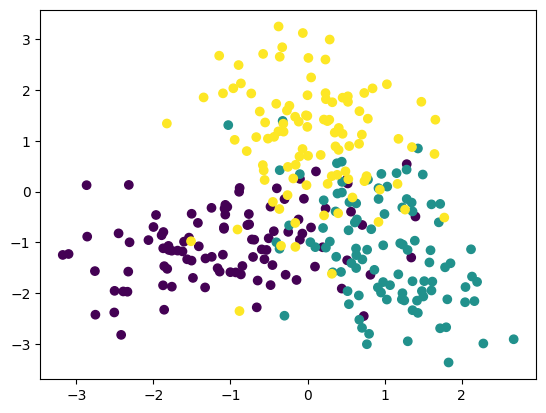

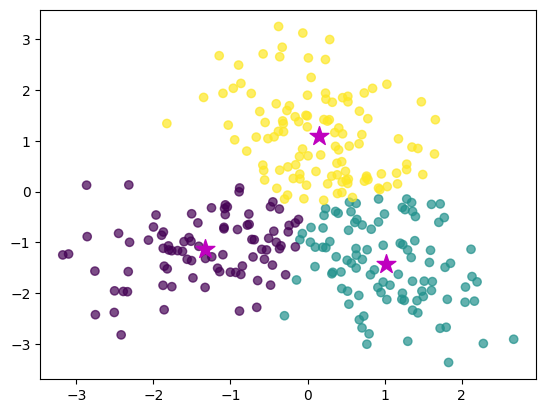

Sigma: 0.5	Accuracy: 0.8066666666666666	Objective Measure: 280.8328516150512
Converged after 9 iterations.


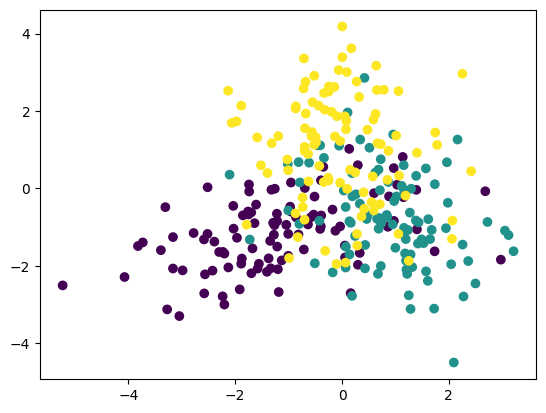

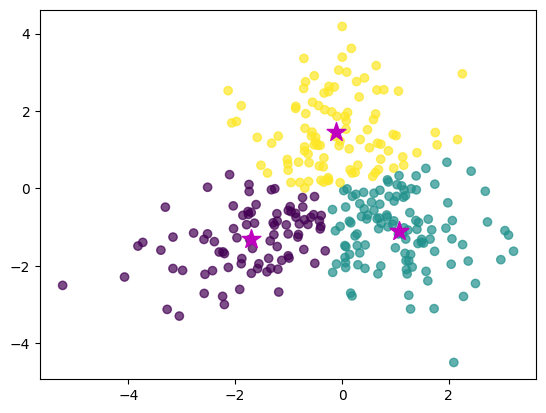

Sigma: 1	Accuracy: 0.7366666666666667	Objective Measure: 330.9026086603826
Converged after 10 iterations.


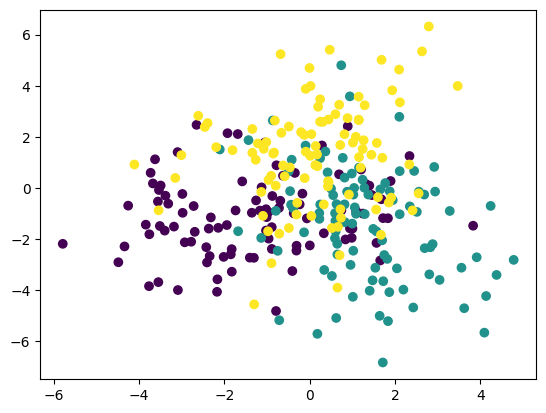

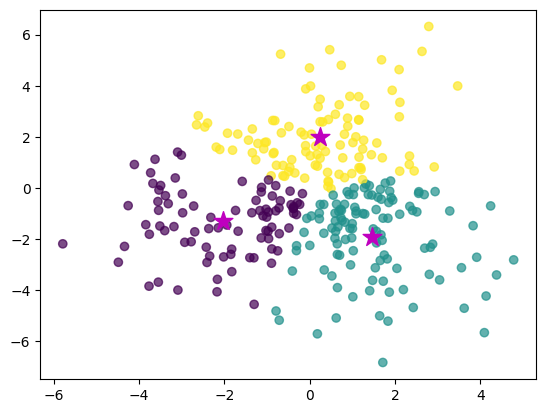

Sigma: 2	Accuracy: 0.68	Objective Measure: 501.2845258210226
Converged after 14 iterations.


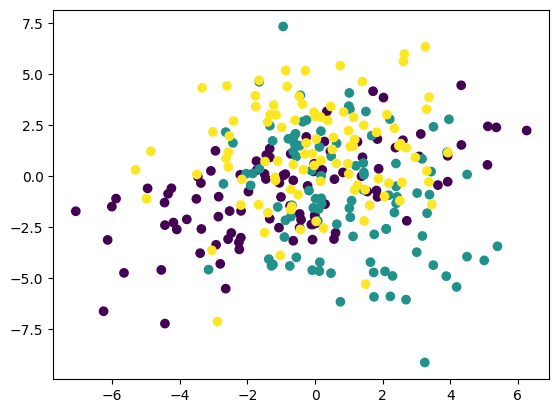

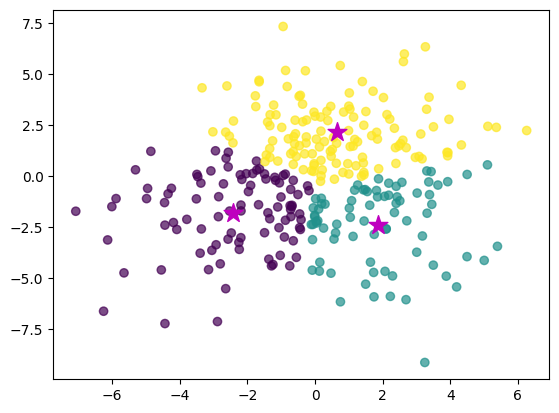

Sigma: 4	Accuracy: 0.54	Objective Measure: 644.7305645624923
Converged after 14 iterations.


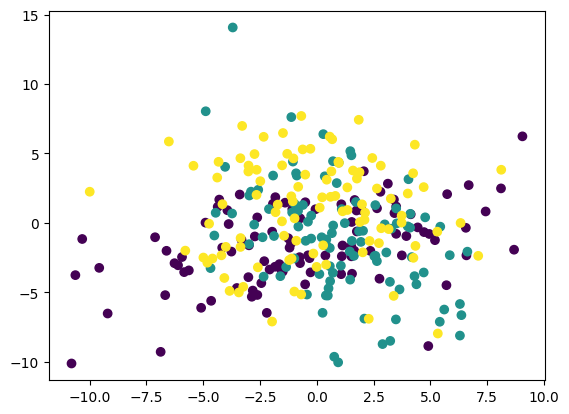

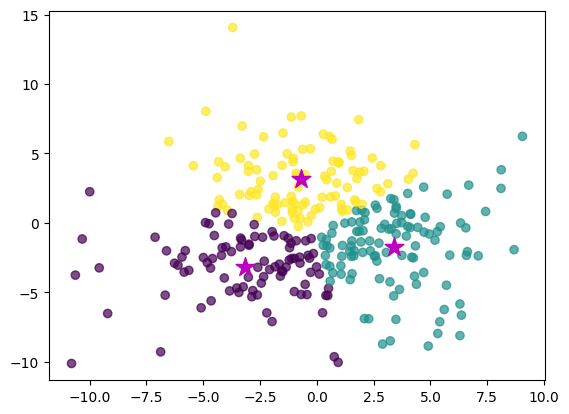

Sigma: 8	Accuracy: 0.49	Objective Measure: 882.1168157649159


In [6]:
# Test K-means clustering
sigmas = [0.5, 1, 2, 4, 8]
km_accs = []
km_objs = []
for sigma in sigmas:
    k = 3
    X, Y = generate_dataset(sigma)
    centroids, Yhat = km_clustering(X, k)
    Yhat = Yhat.astype(int)
    acc, labels = calc_accuracy(Y, Yhat)
    objective = calc_objective(X, Yhat, centroids)
    Yhat = labels[Yhat.astype(int)]
    km_accs.append(acc)
    km_objs.append(objective)
    plt.scatter(x=X[:,0], y=X[:,1], c=Y)
    plt.show()
    plt.scatter(x=X[:,0], y=X[:,1], c=Yhat, alpha=0.7)
    plt.scatter(x=centroids[:,0], y=centroids[:,1], c='m', marker='*', s=200)
    plt.show()
    print('Sigma: ' + str(sigma) + '\tAccuracy: ' + str(acc) + '\tObjective Measure: ' + str(objective))

Converged after 58 iterations.


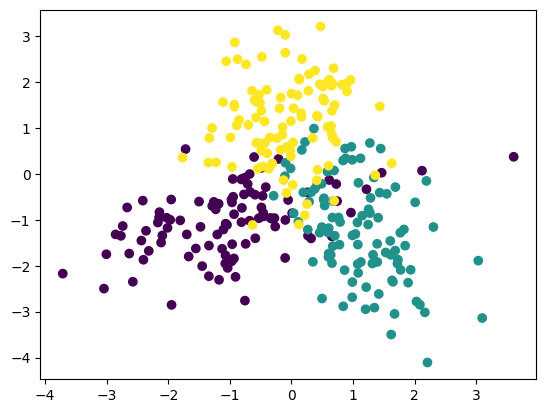

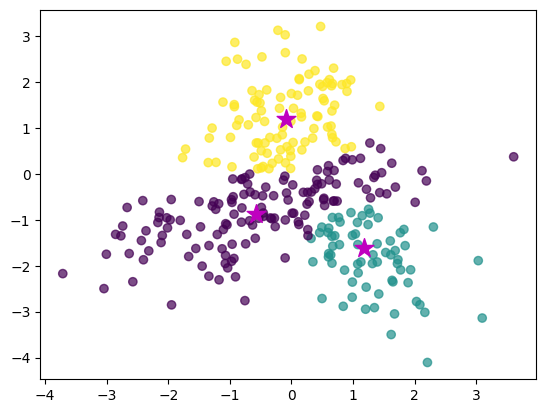

Sigma: 0.5	Accuracy: 0.81	Log Likelihood: -6262.086451027235
Converged after 30 iterations.


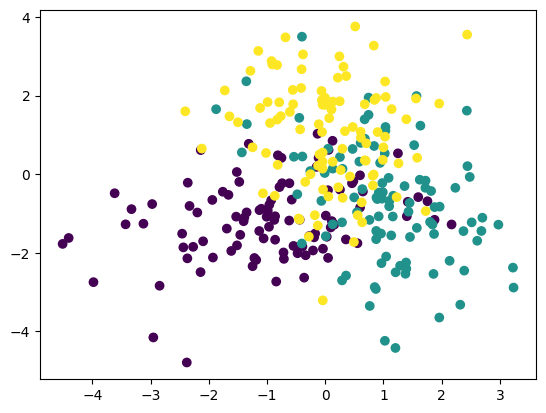

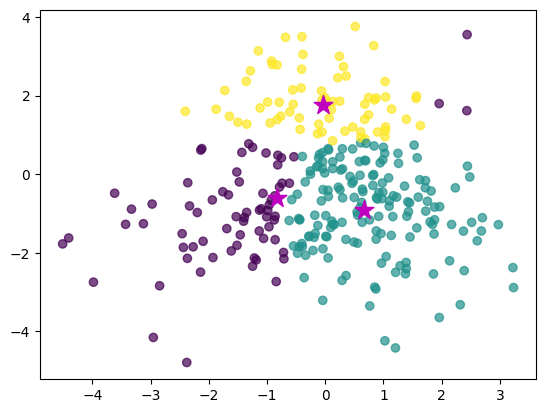

Sigma: 1	Accuracy: 0.66	Log Likelihood: -5597.814663337856
Converged after 439 iterations.


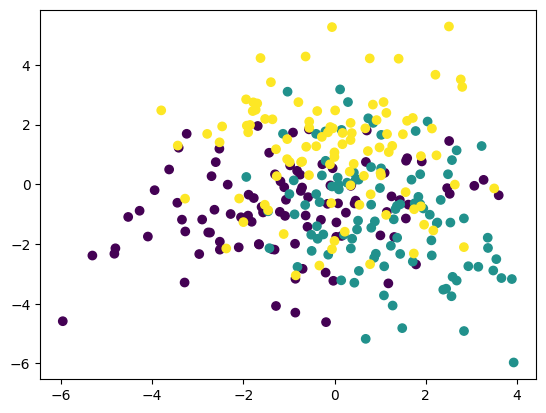

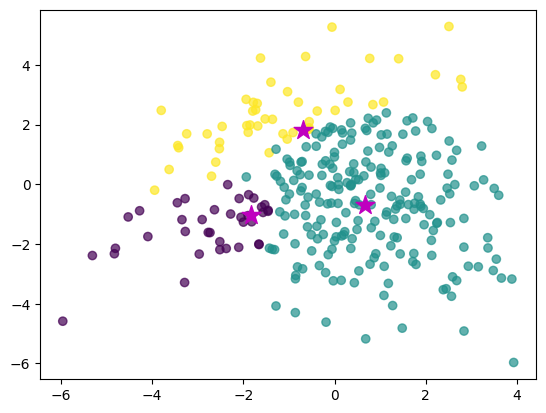

Sigma: 2	Accuracy: 0.5266666666666666	Log Likelihood: -6387.455291276298
Converged after 12 iterations.


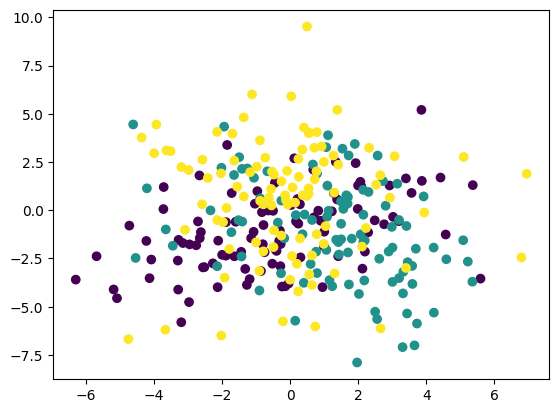

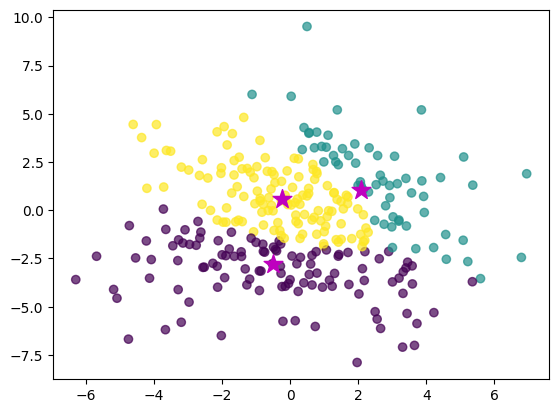

Sigma: 4	Accuracy: 0.42	Log Likelihood: -6161.971643005915
Converged after 88 iterations.


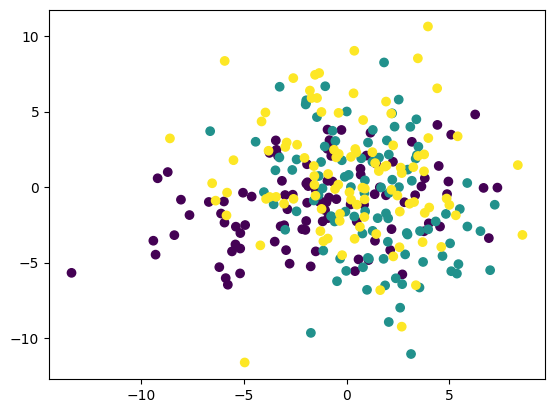

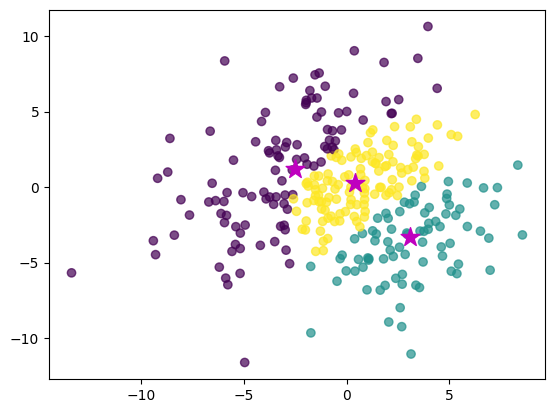

Sigma: 8	Accuracy: 0.42	Log Likelihood: -7390.949952519863


In [7]:
# Test GMM EM clustering
sigmas = [0.5, 1, 2, 4, 8]
gmm_accs = []
gmm_objs = []
for sigma in sigmas:
    k = 3
    X, Y = generate_dataset(sigma)
    means, covs, pZ, W = gmm_clustering(X, k)
    log_likelihood = calc_log_likelihood(X, means, covs, pZ)
    Yhat = np.array([np.argmax(W[i]) for i in range(len(W))])
    acc, labels = calc_accuracy(Y, Yhat)
    Yhat = labels[Yhat.astype(int)]
    gmm_accs.append(acc)
    gmm_objs.append(-log_likelihood)
    plt.scatter(x=X[:,0], y=X[:,1], c=Y)
    plt.show()
    plt.scatter(x=X[:,0], y=X[:,1], c=Yhat, alpha=0.7)
    plt.scatter(x=means[:,0], y=means[:,1], c='m', marker='*', s=200)
    plt.show()
    print('Sigma: ' + str(sigma) + '\tAccuracy: ' + str(acc) + \
          '\tLog Likelihood: ' + str(log_likelihood))

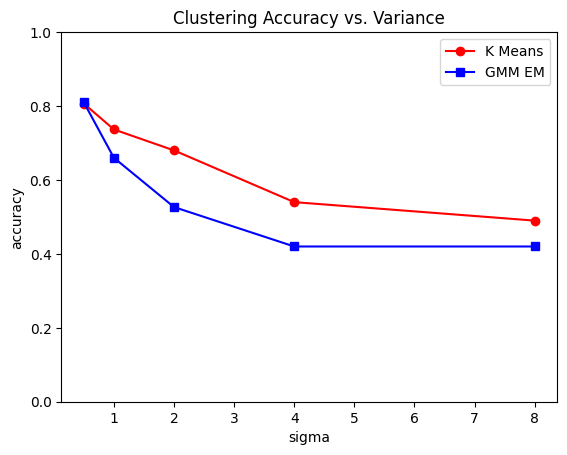

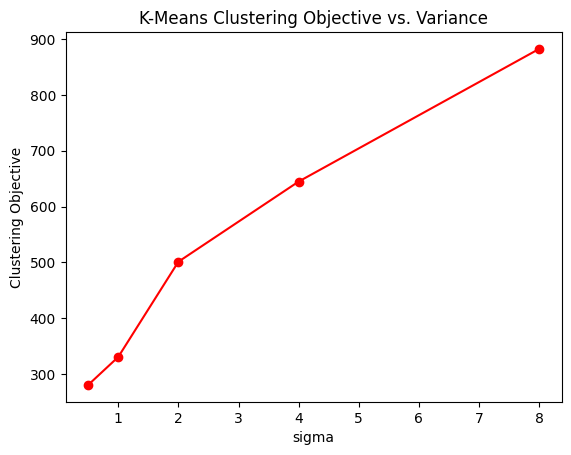

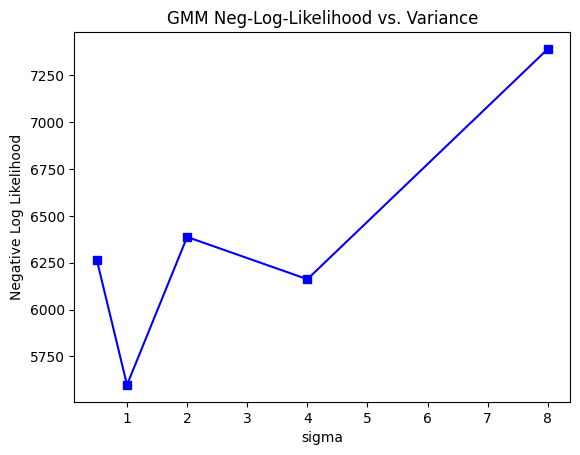

In [8]:
# Plot results
plt.plot(sigmas, km_accs, c='r', marker='o', label='K Means')
plt.plot(sigmas, gmm_accs, c='b', marker='s', label='GMM EM')
plt.ylim((0, 1))
plt.xlabel('sigma')
plt.ylabel('accuracy')
plt.title('Clustering Accuracy vs. Variance')
plt.legend()
plt.show()

plt.plot(sigmas, km_objs, c='r', marker='o')
plt.xlabel('sigma')
plt.ylabel('Clustering Objective')
plt.title('K-Means Clustering Objective vs. Variance')
plt.show()

plt.plot(sigmas, gmm_objs, c='b', marker='s')
plt.xlabel('sigma')
plt.ylabel('Negative Log Likelihood')
plt.title('GMM Neg-Log-Likelihood vs. Variance')
plt.show()